# Практическое занятие 13

## Вариант 11

In [25]:
import networkx as nx
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


class State:
	"""
	Класс, представляющий состояние в марковской модели.
	"""
	def __init__(self, name):
		"""
        Инициализирует новое состояние с заданным именем.

        :param name: Название состояния.
        """
		self.name = name


class Transition:
	"""
	Класс, представляющий переход между состояниями в марковской модели.
	"""
	def __init__(self, from_state, to_state, intensity):
		"""
        Инициализирует новый переход между состояниями с заданной интенсивностью.

        :param from_state: Состояние, из которого происходит переход.
        :param to_state: Состояние, в которое происходит переход.
        :param intensity: Интенсивность перехода.
        """
		self.from_state = from_state
		self.to_state = to_state
		self.intensity = intensity


class MarkovModel:
	"""
	Класс для представления и анализа марковской модели.
	"""
	def __init__(self):
		"""
        Инициализирует модель с пустыми списками состояний и переходов.
        """
		self.states = []
		self.transitions = []

	def add_state(self, state):
		"""
		Добавляет новое состояние в модель.

        :param state: объект State, представляющий состояние.
		"""
		self.states.append(state)

	def add_transition(self, transition):
		"""
		Добавляет новый переход в модель.

        :param transition: объект Transition, представляющий переход.
		"""
		self.transitions.append(transition)

	def get_transition_matrix(self):
		"""
		Создает и возвращает матрицу интенсивностей переходов для модели.

        :return: Матрица интенсивностей переходов.
		"""
		n = len(self.states)
		matrix = np.zeros((n, n))
		for transition in self.transitions:
			from_index = self.states.index(transition.from_state)
			to_index = self.states.index(transition.to_state)
			matrix[from_index, to_index] = transition.intensity
		return matrix

	def kolmogorov_equations(self, t, p, lambda_matrix):
		"""
		Определяет систему дифференциальных уравнений Колмогорова.

        :param t: Текущее время.
        :param p: Массив вероятностей состояний.
        :param lambda_matrix: Матрица интенсивностей переходов.
        :return: Производные вероятностей по времени.
		"""
		dpdt = np.zeros_like(p)
		for i in range(len(p)):
			dpdt[i] = sum(lambda_matrix[j, i] * p[j] for j in range(len(p))) - p[i] * sum(lambda_matrix[i, j] for j in range(len(p)))
		return dpdt

	def solve_kolmogorov(self, t_span, initial_conditions, t_eval):
		"""
		Решает систему уравнений Колмогорова с заданными параметрами.

        :param t_span: Интервал времени для решения.
        :param initial_conditions: Начальные условия системы.
        :param t_eval: Точки времени, в которых вычисляется решение.
        :return: Решение системы уравнений Колмогорова.
		"""
		lambda_matrix = self.get_transition_matrix()
		solution = solve_ivp(self.kolmogorov_equations, t_span, initial_conditions, t_eval=t_eval, args=(lambda_matrix,))
		return solution

	def add_transitions_from_matrices(self, transition_matrix, lambda_matrix):
		"""
		Добавляет переходы в модель на основе матрицы возможных переходов и матрицы интенсивностей.

        :param transition_matrix: Матрица возможных переходов.
        :param lambda_matrix: Матрица интенсивностей переходов.
		"""
		for i, from_state in enumerate(self.states):
			for j, to_state in enumerate(self.states):
				if transition_matrix[i][j] == 1 and lambda_matrix[i][j] > 0:
					self.add_transition(Transition(from_state, to_state, lambda_matrix[i][j]))

	def plot_state_graph(self, transition_matrix, lambda_matrix):
		"""
		Строит и отображает граф состояний модели.

    	:param transition_matrix: Матрица возможных переходов.
        :param lambda_matrix: Матрица интенсивностей переходов.
		"""
		G = nx.DiGraph()
		edge_labels = {}
		for i, from_state in enumerate(self.states):
			for j, to_state in enumerate(self.states):
				if transition_matrix[i][j] == 1:
					forward_label = f"λ{from_state.name[1:]}{to_state.name[1:]}: {lambda_matrix[i][j]}"
					reverse_label = ""
					if transition_matrix[j][i] == 1:
						reverse_label = f"λ{to_state.name[1:]}{from_state.name[1:]}"

						if lambda_matrix[i][j] != lambda_matrix[j][i]:
							reverse_label += "'"

						reverse_label += f": {lambda_matrix[j][i]}"

					label = forward_label
					if reverse_label:
						label += " / " + reverse_label

					G.add_edge(from_state.name, to_state.name)
					edge_labels[(from_state.name, to_state.name)] = label

		#pos = nx.spring_layout(G)
		pos = nx.circular_layout(G)

		plt.figure(figsize=(12, 8))
		nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=12, arrowsize=20)
		nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='green')
		plt.title("Граф состояний системы с интенсивностями переходов")
		plt.show()

	def plot_solution(self, solution):
		"""
		Визуализирует решение системы уравнений Колмогорова.

        :param solution: Решение системы уравнений Колмогорова, возвращаемое функцией solve_ivp.
		"""
		plt.figure(figsize=(12, 8))
		for i, state in enumerate(self.states):
			plt.plot(solution.t, solution.y[i], label=f'{state.name}(t)')

		plt.title('Вероятности состояний системы в зависимости от времени')
		plt.xlabel('Время')
		plt.ylabel('Вероятность')
		plt.legend()
		plt.grid(True)
		plt.show()


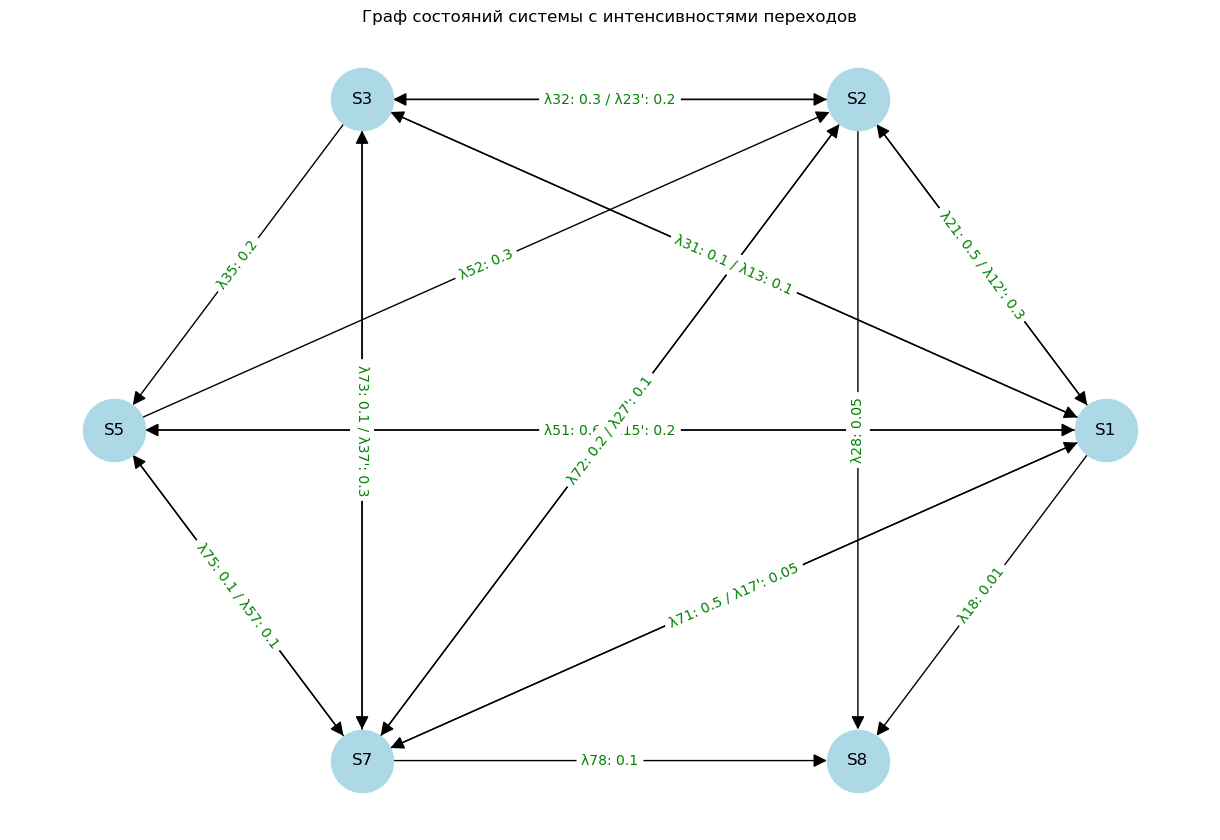

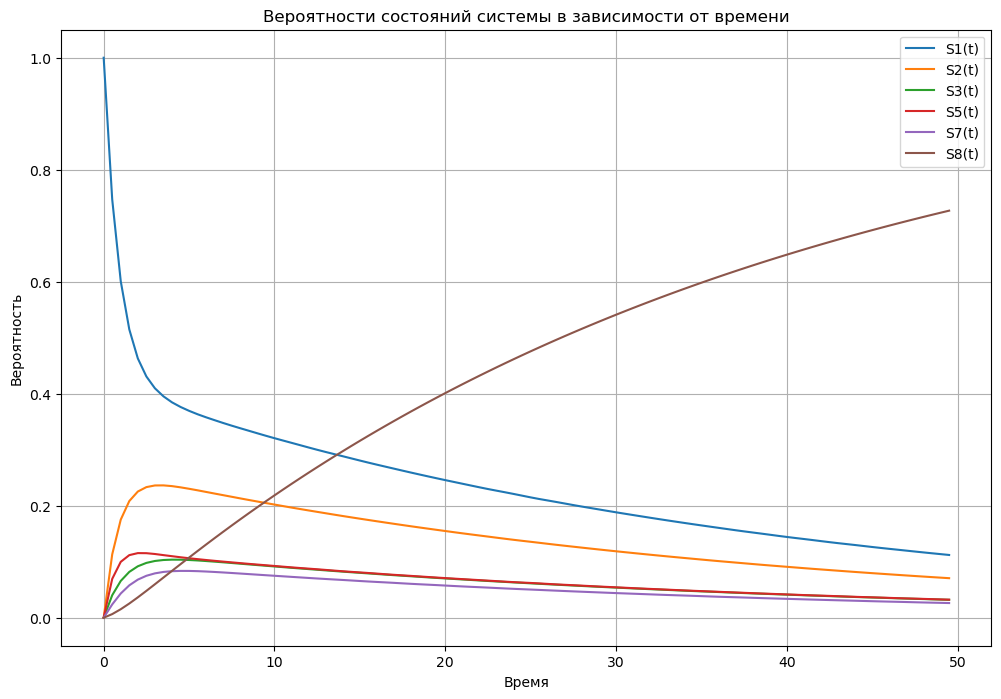

In [26]:
model = MarkovModel()

# Состояния
states = ["S1", "S2", "S3", "S5", "S7", "S8"]

# Создание и добавление состояний
model.states = list(map(lambda state_name: State(state_name), states))

# Матрица переходов
transition_matrix = [
	[0, 1, 1, 1, 1, 1],
	[1, 0, 1, 0, 1, 1],
	[1, 1, 0, 1, 1, 0],
	[1, 1, 0, 0, 1, 0],
	[1, 1, 1, 1, 0, 1],
	[0, 0, 0, 0, 0, 0]
]

# Матрица интенсивностей
lambda_values = [
	[0, 0.3, 0.1, 0.2, 0.05, 0.01],
	[0.5, 0, 0.2, 0, 0.1, 0.05],
	[0.1, 0.3, 0, 0.2, 0.3, 0.1],
	[0.6, 0.3, 0, 0, 0.1, 0],
	[0.5, 0.2, 0.1, 0.1, 0, 0.1],
	[0, 0, 0, 0, 0, 0]
]

model.add_transitions_from_matrices(transition_matrix, lambda_values)

# Решение системы уравнений
t_span = [0, 50]
initial_conditions = [1, 0, 0, 0, 0, 0]
t_eval = np.arange(t_span[0], t_span[1], 0.5)
solution = model.solve_kolmogorov(t_span, initial_conditions, t_eval)

# Визуализация решения
model.plot_state_graph(transition_matrix, lambda_values)
model.plot_solution(solution)

#### Входные данные

**Пусть физическая система S – сервер, которая при проверке, проводимой в процессе эксплуатации, может оказаться в одном из следующем состоянии:**
- S1 – сервер полностью исправен;
- S2 – сервер имеет незначительные неисправности, при которых он может решать задачи;
- S3 – сервер имеет существенные неисправности и может решать ограниченное число задач;
- S4 – сервер полностью вышел из строя;
- S5 – сервер находится на профилактике;
- S6 – сервер не работает по организационным причинам;
- S7 – сервер не работает в праздничные и другие нерабочие дни;
- S8 – сервер списывается.

![](13.png)

#### Интенсивности из состояния S1 (полностью исправен):
- $\lambda_{12}$: 0.3 (незначительные неисправности могут возникать иногда)
- $\lambda_{13}$: 0.1 (существенные неисправности возникают редко)
- $\lambda_{15}$: 0.2 (периодическая профилактика)
- $\lambda_{17}$: 0.05 (выход из строя в рабочие дни редок)
- $\lambda_{18}$: 0.01 (списание сервера - очень редкое событие)

#### Интенсивности из состояния S2 (незначительные неисправности):
- $\lambda_{21}$: 0.5 (высокая вероятность быстрого устранения проблем)
- $\lambda_{23}$: 0.2 (возможность ухудшения состояния)
- $\lambda_{27}$: 0.1 (некоторые серверы могут выходить из строя)
- $\lambda_{28}$: 0.05 (реже списываются)

#### Интенсивности из состояния S3 (существенные неисправности):
- $\lambda_{31}$: 0.1 (редкое восстановление до полной исправности)
- $\lambda_{32}$: 0.3 (чаще устраняются до незначительных неисправностей)
- $\lambda_{35}$: 0.2 (нуждается в профилактике)
- $\lambda_{37}$: 0.3 (высокий риск выхода из строя)
- $\lambda_{38}$: 0.1 (некоторые могут быть списаны)

#### Интенсивности из состояния S5 (на профилактике):
- $\lambda_{51}$: 0.6 (часто возвращаются в исправное состояние)
- $\lambda_{52}$: 0.3 (иногда обнаруживаются незначительные неисправности)
- $\lambda_{57}$: 0.1 (редко выходят из строя во время профилактики)

#### Интенсивности из состояния S7 (не работает в нерабочие дни):
- $\lambda_{71}$: 0.5 (обычно возвращаются в рабочее состояние)
- $\lambda_{72}$: 0.2 (могут обнаруживаться незначительные неисправности)
- $\lambda_{73}$: 0.1 (иногда возникают существенные неисправности)
- $\lambda_{75}$: 0.1 (некоторые отправляются на профилактику)
- $\lambda_{78}$: 0.1 (редко списываются)

#### Из состояния S8 (списывается) переходов нет, так как это конечное состояние.